<a href="https://colab.research.google.com/github/vaibhavlokunde/AI-ML/blob/main/DC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

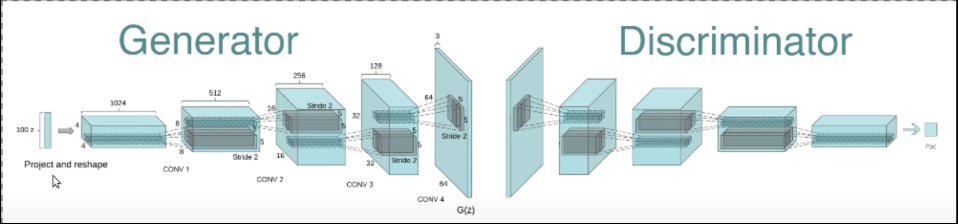

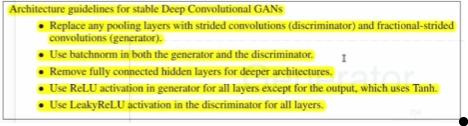

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
import math
import itertools
from glob import glob
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"
device

'cuda'

`noise_vector`: is the length of the z input vector

`num_gen_filter`:size of the feature maps thats are propagated through the generator

`num_ch`:the number of channels in the output image

Here,the height and width dimension of the image does not change, only the channel dimension increases.


#We are using MNIST dataset thus the num_ch wll be 1 as its grey scale

In generator the layers will keep decreasing, But in discriminator its increasing

In [3]:
class Generator(nn.Module):
  def __init__(self,output_channels,noise_vector,hidden_units):
    super(Generator,self).__init__()
    self.network=nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=noise_vector,
            out_channels=hidden_units*4,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
        ),
        nn.BatchNorm2d(hidden_units*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=hidden_units*4,
            out_channels=hidden_units*2,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=hidden_units*2,
            out_channels=hidden_units,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=hidden_units,
            out_channels=output_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.Tanh()
    )

  def forward(self,input):
    return self.network(input)

In [4]:
class Discriminator(nn.Module):
  def __init__(self,output_channels,hidden_units):
    super(Discriminator,self).__init__()
    self.network=nn.Sequential(
        nn.Conv2d(
            in_channels=output_channels,
            out_channels=hidden_units,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units*2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(hidden_units*2),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=hidden_units*2,
            out_channels=hidden_units*4,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(hidden_units*4),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=hidden_units*4,
            out_channels=1,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
        ),
        nn.Sigmoid()
    )

  def forward(self,input):
    output=self.network(input)
    return output.view(-1,1).squeeze(1) #we do this bcuz we want a 1D output


In [6]:
def get_data_loader(batch_size):
  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.1307),std=(0.3081))
  ])

  train_data=datasets.MNIST(
      root="data",
      train=True,
      download=True,
      transform=transform
  )

  train_dataloader=DataLoader(
      dataset=train_data,
      batch_size=batch_size,
      shuffle=True
  )
  return train_dataloader

In [15]:
def plot_images(epoch, path, num_test_samples, generator, device):
    """
    This function generates a set of images using the provided generator model, and plots
    them in a grid structure.

    Parameters
    ----------
    epoch : int
        The current training epoch. Used for labeling the plot.
    path : str
        The path where the images will be saved.
    num_test_samples : int
        The number of images to generate and plot.
    generator : torch.nn.Module
        The generator model to use for creating the images.
    device : torch.device
        The device (CPU or GPU) where the generator model is located.

    Returns
    -------
    None
    """
    # Generate a random noise tensor with shape (num_test_samples, 100, 1, 1)
    # which will be used as input to the generator model to create images.
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)

    # Calculate the size of the grid to plot based on the number of test samples.
    plot_grid_size = int(math.sqrt(num_test_samples))

    # Generate the images using the generator model.
    generated_fake_images = generator(z)

    # Append "variable_noise/" to the save path.
    path += "variable_noise/"

    # Initialize the title of the plot.
    title = "Variable Noise"

    # Create a figure with a grid of subplots.
    fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(6, 6))

    # Hide the x and y axes of all subplots.
    for i, j in itertools.product(range(plot_grid_size), range(plot_grid_size)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    # Plot each of the generated images in its own subplot.
    for sample in range(num_test_samples):
        i = sample // 4
        j = sample % 4
        ax[i, j].cla()
        ax[i, j].imshow(
            generated_fake_images[sample].data.cpu().numpy().reshape(28, 28),
            cmap="Greys",
        )

    # Add a label for the epoch at the bottom of the plot.
    label = "Epoch_{}".format(epoch + 1)
    fig.text(0.5, 0.04, label, ha="center")

    # Add the title to the plot.
    fig.suptitle(title)

##TRAINING AND TESTING DCGAN

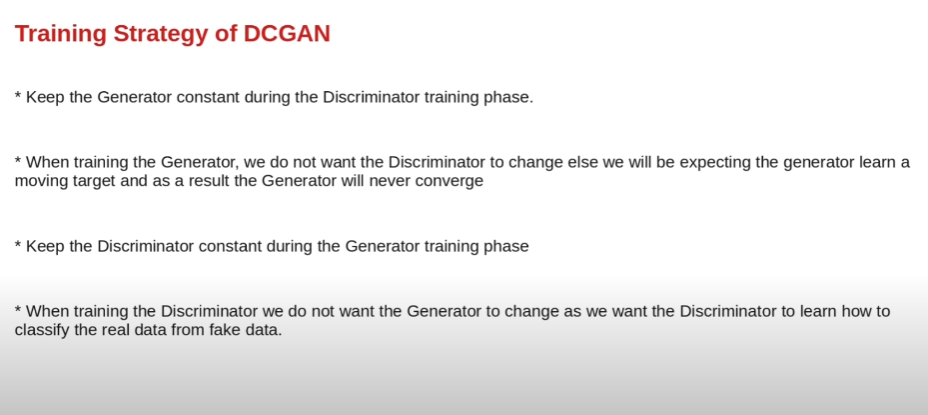

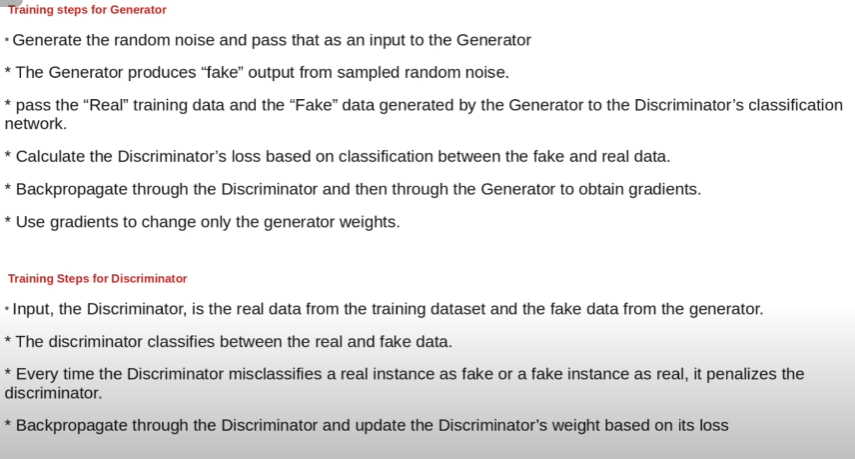

5. Discriminator Training (for each batch)

Train on real images: Pass real images through the discriminator, compute loss against real labels
Generate fake images: Pass random noise through the generator to create fake images
Train on fake images: Pass these fake images through the discriminator, compute loss against fake labels
Combine losses and update: Add both losses and use optimizer to update discriminator weights
Purpose: Teach the discriminator to correctly identify real and fake images

6. Generator Training (for each batch)

Generate new fake images: Create another batch of fake images from random noise
Fool the discriminator: Pass fake images through the discriminator, but compute loss against real labels
Update generator: Use this "fooling loss" to update only the generator weights
Purpose: Train the generator to create images that the discriminator can't distinguish from real ones

In [8]:
def train(num_epochs,
    discriminator_net,
    generator_net,
    optimizerD,
    optimizerG,
    train_dataloader,
    fake_label,
    real_label,
    criterion,
    output_path,
    num_test_samples,
    device,
    noise_vector):
    num_batches = len(train_dataloader)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_dataloader):
            batch_size_real_images = real_images.shape[0]

            discriminator_net.zero_grad()

            real_images = real_images.to(device)

            # Fixed: The second parameter in torch.full should be a value, not 0
            label = torch.full((batch_size_real_images,), real_label, device=device)

            # First Training Discriminator Against real images
            y_pred = discriminator_net(real_images)

            loss_disc_real = criterion(y_pred, label)
            # Added: loss_disc_real.backward() was missing
            loss_disc_real.backward()

            D_x = y_pred.mean().item()

            # Now training it under Fake images....we first generate it using noise
            noise = torch.randn(batch_size_real_images, noise_vector, 1, 1, device=device)

            fake_images = generator_net(noise)

            label.fill_(fake_label)

            y_pred = discriminator_net(fake_images.detach())

            loss_disc_fake = criterion(y_pred, label)
            # Fixed: This backward call was incorrect - should be on loss_disc_fake, not loss_disc_total
            loss_disc_fake.backward()

            D_G_z1 = y_pred.mean().item()

            # Total Discriminator loss
            # Fixed: Moved this line above optimizer step, but after both backward calls
            loss_disc_total = loss_disc_real + loss_disc_fake

            optimizerD.step()

            # Training Generator
            generator_net.zero_grad()

            label.fill_(real_label)

            y_pred = discriminator_net(fake_images)

            loss_gen = criterion(y_pred, label)

            loss_gen.backward()
            D_G_z2 = y_pred.mean().item()

            optimizerG.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}".format(
                        epoch + 1,
                        num_epochs,
                        i + 1,
                        num_batches,
                        loss_disc_total.item(),
                        loss_gen.item(),
                        D_x,
                        D_G_z1,
                        D_G_z2,
                    )
                )

        # Fixed: Moved these outside the batch loop - should only run once per epoch
        generator_net.eval()
        plot_images(
            epoch,
            output_path,
            num_test_samples,
            generator_net,
            device,
        )
        generator_net.train()

In [9]:
batch_size = 256

output_path = "/content/sample_data/"

In [10]:
train_dataloader = get_data_loader(batch_size)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.81MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]


In [11]:
# Create the Discriminator and Generator network
discriminator_net = Discriminator(output_channels=1, hidden_units=32).to(device)

generator_net = Generator(output_channels=1, noise_vector=100, hidden_units=32).to(device)

In [12]:
# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(discriminator_net.parameters(), lr=0.001)
optimizerG = optim.Adam(generator_net.parameters(), lr=0.001)

In [13]:
# initialize variables required for training
real_label = 1.0
fake_label = 0.0
# num_batches = len(train_loader)

num_test_samples = 16

fixed_noise = torch.randn(num_test_samples, 100, 1, 1, device=device)

num_epochs = 20

noise_vector = 100

Epoch [1/20], step [100/235], d_loss: 0.0019, g_loss: 9.7180, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/20], step [200/235], d_loss: 0.0080, g_loss: 7.6898, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/20], step [100/235], d_loss: 0.0016, g_loss: 8.6148, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/20], step [200/235], d_loss: 0.0029, g_loss: 8.2095, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/20], step [100/235], d_loss: 0.0026, g_loss: 8.2287, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/20], step [200/235], d_loss: 0.0797, g_loss: 4.6866, D(x): 0.98, Discriminator - D(G(x)): 0.05, Generator - D(G(x)): 0.02
Epoch [4/20], step [100/235], d_loss: 0.0297, g_loss: 7.7516, D(x): 0.98, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [4/20], step [200/235], d_loss: 0.0175, g_loss: 7.5731, D(x): 0.99, Discrimin

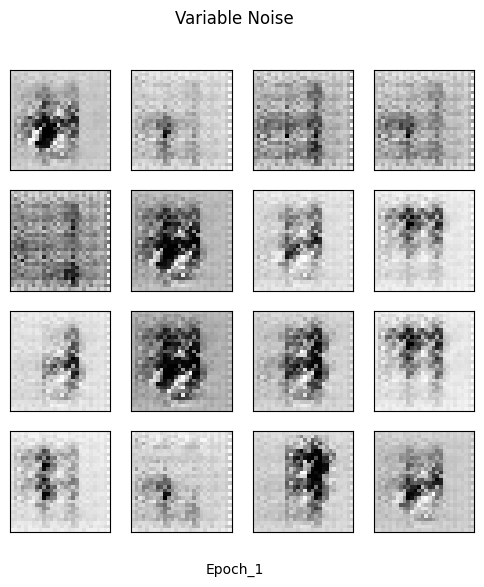

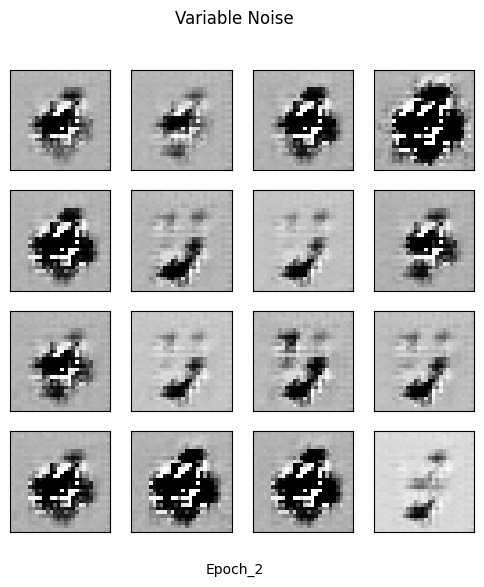

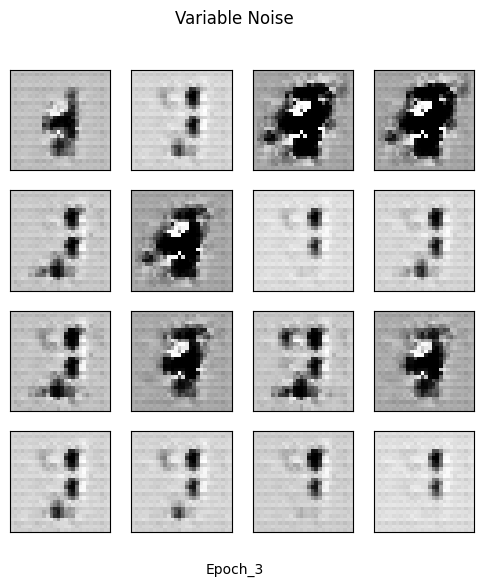

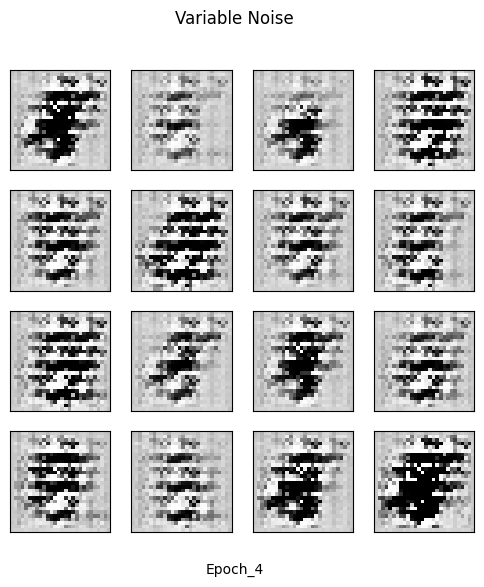

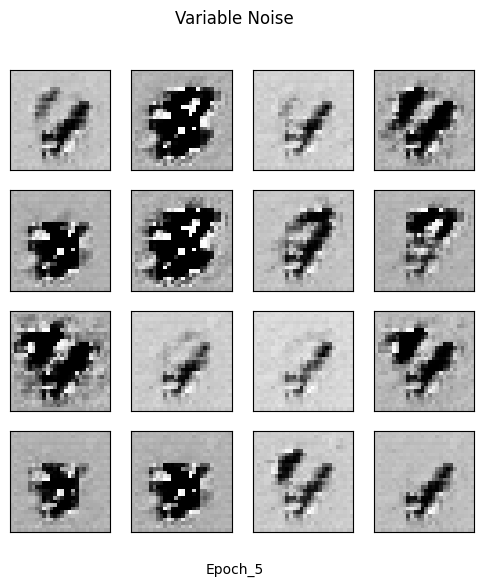

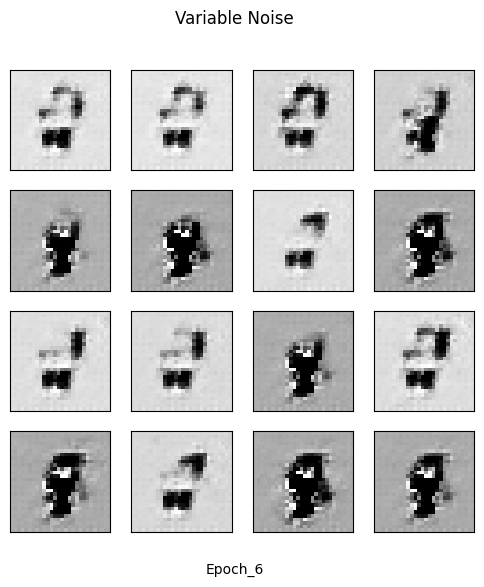

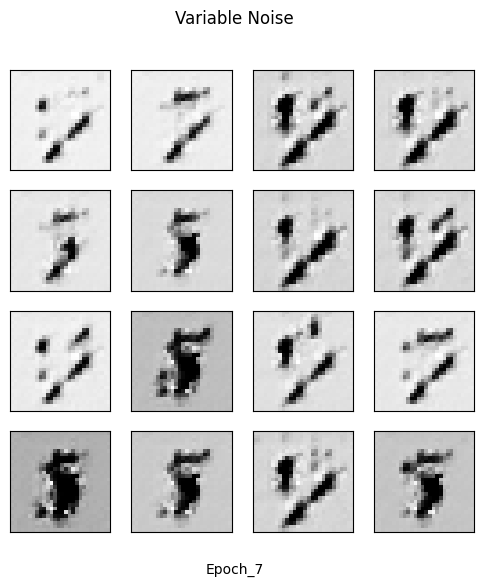

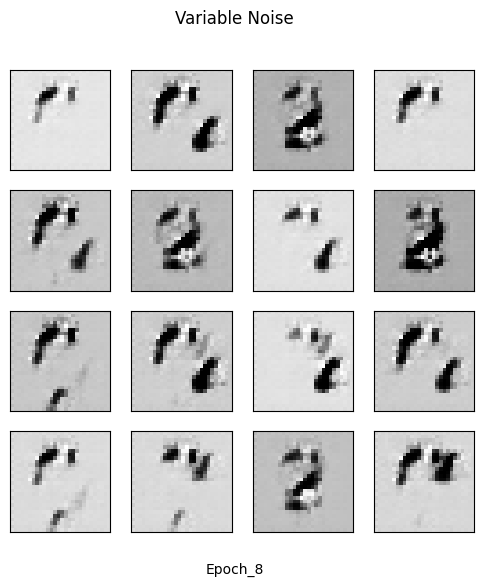

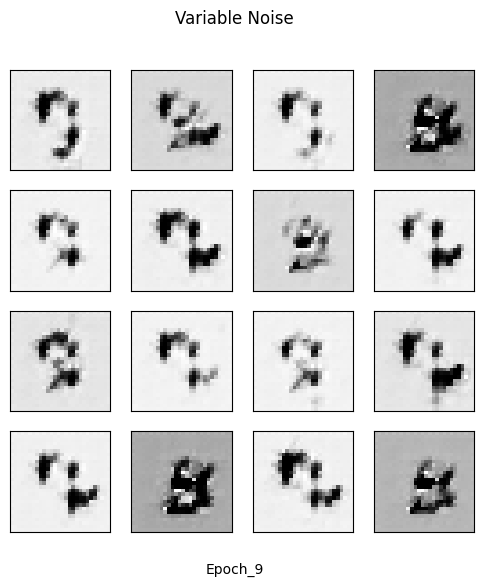

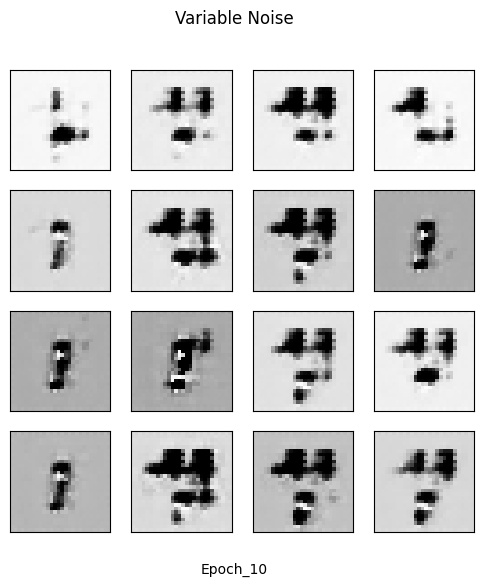

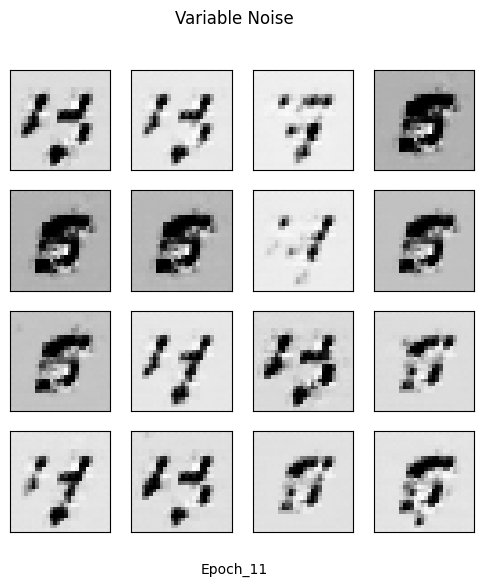

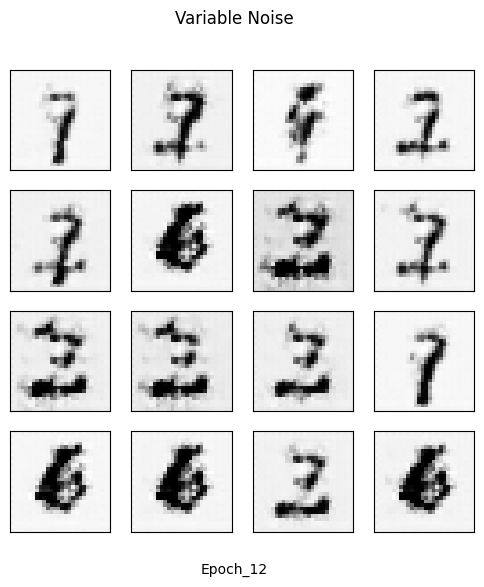

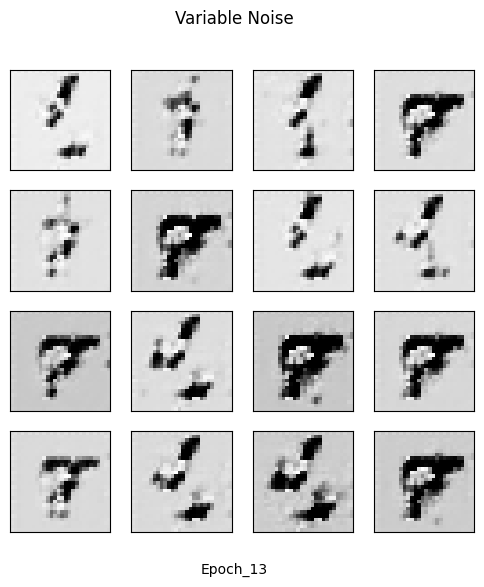

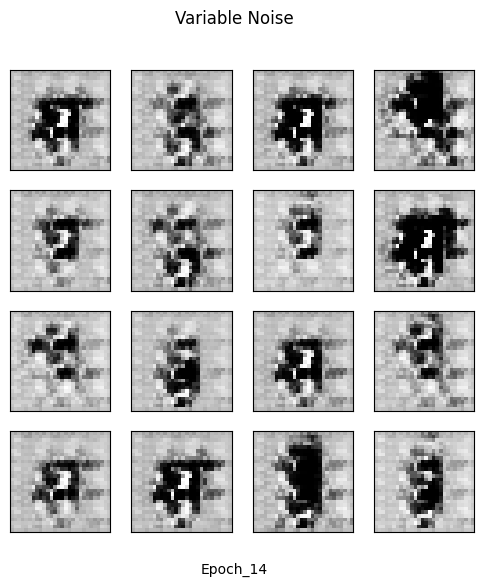

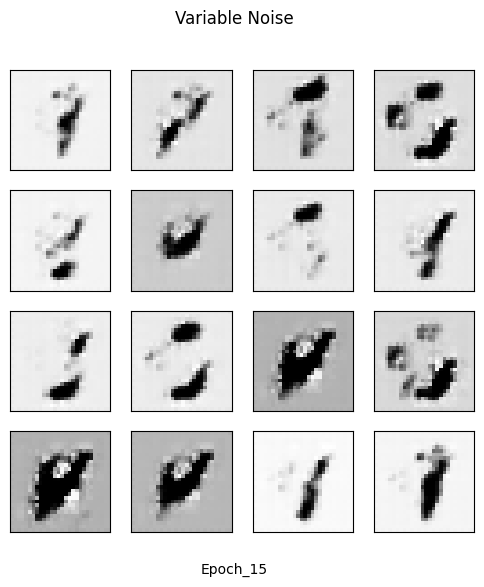

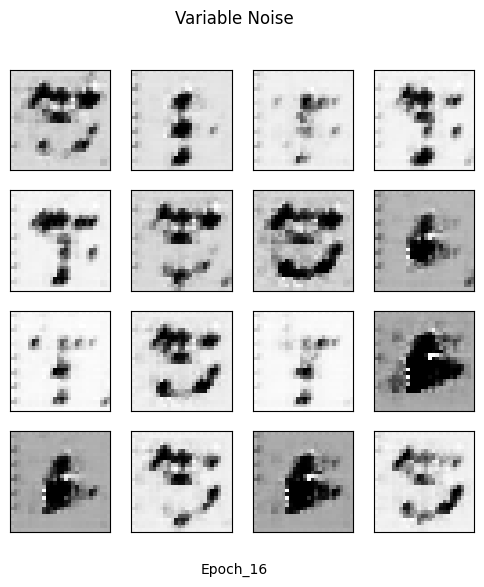

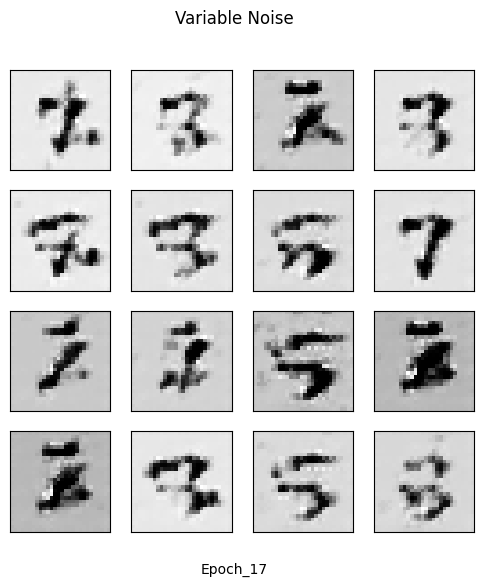

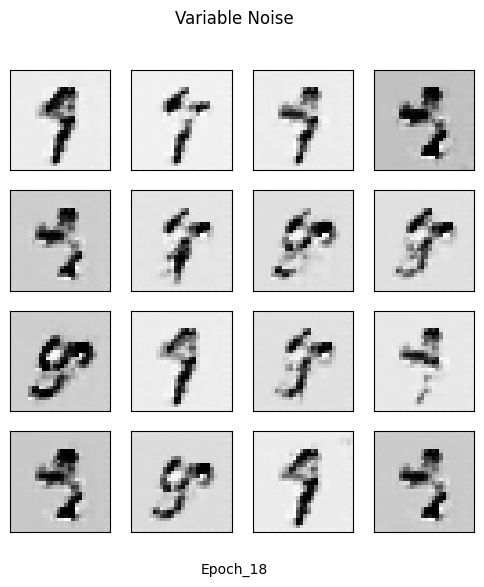

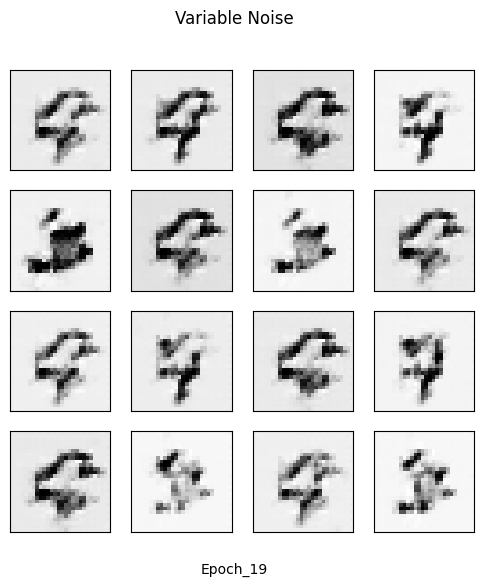

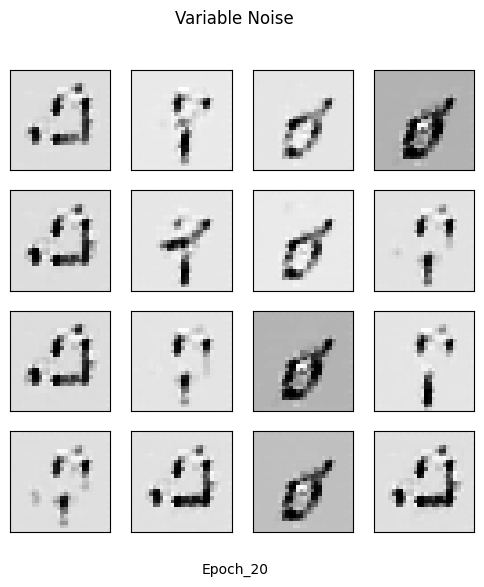

In [16]:
train(
    num_epochs=num_epochs,
    discriminator_net=discriminator_net,
    generator_net=generator_net,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    train_dataloader=train_dataloader,
    fake_label=fake_label,
    real_label=real_label,
    criterion=criterion,
    output_path=output_path,
    num_test_samples=num_test_samples,
    device=device,
    noise_vector=noise_vector,
)